In [1]:
import pyro
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Callable
from collections import Counter
from tqdm import tqdm

sns.set_theme(style="darkgrid")

# Practice Chapter 4

## Easy

### 4E1

In the model definition below, which line is the likelihood?
```
yi ∼ Normal(µ, σ)
µ ∼ Normal(0, 10)
σ ∼ Exponential(1)
```

**Solution**:

The first one, i.e. yi.

### 4E2

In the model definition just above, how many parameters are in the posterior distribution?

**Solution**:

There are two parameters, i.e. $\mu$ and $\sigma$.

### 4E3

Using the model definition above, write down the appropriate form of Bayes’ theorem that includes the proper likelihood and priors.

**Solution**:

$$
Pr(\mu, \sigma|y_i) \propto Pr(y_i| \mu, \sigma) Pr_\mu(\mu) Pr_\sigma(\sigma)
$$
with $Pr(\cdot| \mu, \sigma)$, $Pr_\mu(\cdot)$, and $Pr_\sigma(\cdot)$ being `Normal(µ, σ)`, `Normal(0, 10)`, and `Exponential(1)`.

### 4E4

In the model definition below, which line is the linear model?
```
yi ∼ Normal(µ, σ)
µi = α + β xi
α ∼ Normal(0, 10)
β ∼ Normal(0, 1)
σ ∼ Exponential(2)
```

**Solution**:

The second line, i.e. µi = ... .

### 4E5

In the model definition just above, how many parameters are in the posterior distribution?

**Solution**:

There are three parameters in the postirior, i.e. α, β, and σ.

## Medium

### 4M1

For the model definition below, simulate observed y values from the prior (not the posterior). 
```
yi ∼ Normal(µ, σ)
µ ∼ Normal(0, 10)
σ ∼ Exponential(1)
```

In [2]:
sample_mu = pyro.sample('mu', pyro.distributions.Normal(0, 10.), (5000,))

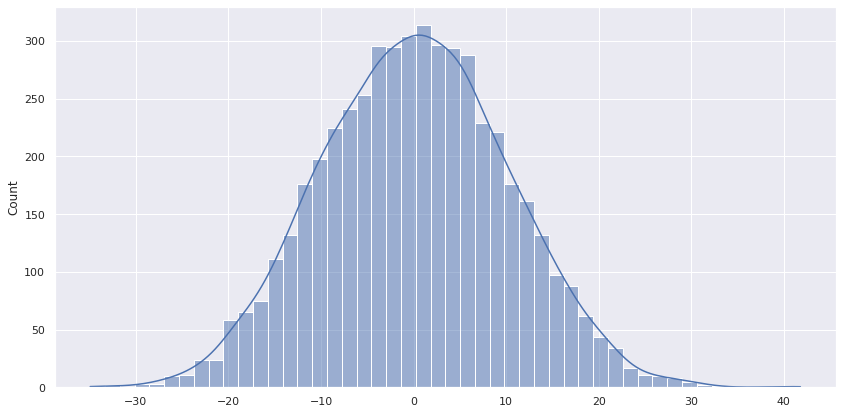

In [3]:
plt.figure(figsize=(14, 7))
sns.histplot(sample_mu, kde=True);

In [4]:
sample_sigma = pyro.sample('sigma', pyro.distributions.Exponential(1.), (5000,))

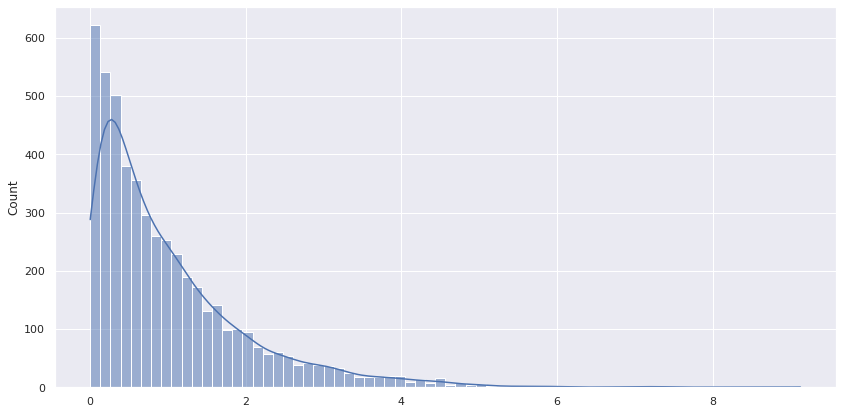

In [5]:
plt.figure(figsize=(14, 7))
sns.histplot(sample_sigma, kde=True);

### 4M2

Translate the model just above into a quap formula.

In [6]:
def model_xy(data: float):
    mu = pyro.sample("mu", pyro.distributions.Normal(0, 10))
    sigma = pyro.sample("sigma", pyro.distributions.Exponential(1.))
    return pyro.sample("y", pyro.distributions.Normal(mu, sigma), obs=data)

### 4M3

Translate the quap model formula below into a mathematical model definition.
```
flist <- alist(
y ~ dnorm( mu , sigma ), mu <- a + b*x, a ~ dnorm( 0 , 10 ), b ~ dunif( 0 , 1 ), sigma ~ dexp( 1 )
)
```

**Solution**:

The above model can be written as:
$$
y_i \sim \text{Normal}(\mu_i,\sigma)\\
\mu_i = a + b\, x_i\\
a \sim \text{Normal}(0,10)\\
b \sim \text{Uniform}(0,1)\\
\sigma \sim \text{Exponential}(1)
$$

### 4M4

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

**Solution**:

A possible model could be:
$$
height_i \sim \text{Normal}(\mu_i,\sigma)\\
\mu_i = a + b\, \text{age}_i\\
a \sim \text{Uniform}(80,210)\\
b \sim \text{Uniform}(0,50)\\
\sigma \sim \text{Exponential}(0.2)
$$

### 4M5

Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?

**Solution**:

No, the prior for $b$ was chosen such that the stundents grow (on average) between 0 and 50 cm per year.

### 4M6

Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

In [7]:
np.sqrt(64)

8.0

**Solution**:

With this additional information we can either restrict the (exponential) distribution of $\sigma$ by multiplying with Uniform$(0,8)$ (and rescale it) or just use the uniform distribution itself, i.e.
$$
\sigma \sim \text{Uniform}(0.8)
$$

## Hard

### 4H1

The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

Individual | weight | expected height | 89% interval
:---------:|:------:|:---------------:|:-----------:
1 | 46.95 | | 
2 | 43.72 | | 
3 | 64.78 | | 
4 | 32.59 | | 
5 | 54.63 | | 

In [8]:
weights_ = torch.tensor([46.95, 43.72, 64.78, 32.59, 54.63 ])

In [9]:
! ls -lh ../data | grep Howell

-rw-rw-r-- 1 docker docker  12K Oct 20 10:37 Howell1.csv
-rw-rw-r-- 1 docker docker  21K Oct 20 10:37 Howell2.csv


In [10]:
data = pd.read_csv("../data/Howell1.csv", sep=";")
data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


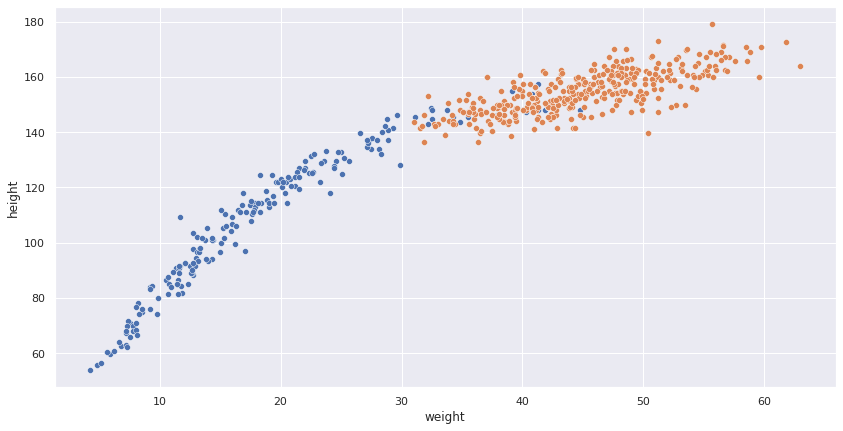

In [11]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=data, x='weight', y='height');
data_adults = data[data['age'] >= 18]
sns.scatterplot(data=data_adults, x='weight', y='height');

In [12]:
from pyro.infer.autoguide import AutoLaplaceApproximation
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import Predictive, SVI, Trace_ELBO
# define the average weight, x-bar
xbar = data_adults.weight.mean()

# fit model
def model(weight, height=None):
    a = pyro.sample("a", dist.Normal(150, 20))
    b = pyro.sample("b", dist.LogNormal(0, 3))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    mu = pyro.deterministic("mu", a + b * (weight - torch.tensor(xbar)))
    pyro.sample("height", dist.Normal(mu, sigma), obs=height)


guide = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    guide,
    optim.Adam({"lr": 0.0005, "betas": (0.90, 0.999)}),
    Trace_ELBO(),
)
for i in tqdm(range(10000)):
    svi.step(torch.tensor(data_adults.weight.values), torch.tensor(data_adults.height.values))

100%|██████████| 10000/10000 [00:31<00:00, 321.91it/s]


In [13]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

In [14]:
sample_heights = predictive(weights_)['height']

In [15]:
heights_ = torch.mean(sample_heights, 0)

In [16]:
def HPDI(probability_samples: list, p=0.83) -> Tuple[float, float]:
    num_samples = len(probability_samples)
    samples_sorted = sorted(probability_samples)
    intervals = [
        (samples_sorted[int(p*num_samples) + i], samples_sorted[i])
        for i in range(num_samples - int(p*num_samples))
    ]

    return sorted(intervals, key=lambda x: x[0] - x[1])[0]

In [17]:
intervals = [HPDI(samples_.detach().numpy(), p=0.83) for samples_ in sample_heights.T]

In [18]:
for i, (w, h, inter) in enumerate(zip(weights_, heights_, intervals)):
    print(f"{i + 1} | {w:.2f} | {h:.2f} | [{inter[1]:.2f}, {inter[0]:.2f}]")

1 | 46.95 | 156.28 | [149.37, 163.11]
2 | 43.72 | 153.11 | [146.57, 159.80]
3 | 64.78 | 172.33 | [166.14, 180.12]
4 | 32.59 | 143.56 | [137.57, 151.34]
5 | 54.63 | 163.26 | [157.22, 170.79]


The final result is therefore:

Individual | weight | expected height | 89% interval
:---------:|:------:|:---------------:|:-----------:
1 | 46.95 | 156.27 | [150.38, 164.48]
2 | 43.72 | 153.58 | [147.06, 161.18]
3 | 64.78 | 172.81 | [165.59, 179.25]
4 | 32.59 | 143.56 | [136.57, 150.48]
5 | 54.63 | 163.26 | [156.01, 170.01]

### 4H2

Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

1. Fit a linear regression to these data, using quap. Present and interpret the estimates. For every 10 units of increase in weight, howmuch taller does the model predict a child gets?
2. Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.
3. What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

### 4H3

Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.

1. Model the relationship between height (cm) and the natural logarithmofweight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Fit this model, using quadratic approximation:
```
hi ∼ Normal(µi, σ)
µi = α + β log(wi)
α ∼ Normal(178, 20)
β ∼ Log − Normal(0, 1)
σ ∼ Uniform(0, 50)
```
where hi is the height of individual i and wi is the weight (in kg) of individual i. The function for computing a natural log in R is just log. Can you interpret the resulting estimates?
2. Begin with this plot:
```
plot( height ~ weight , data=Howell1 , col=col.alpha(rangi2,0.4) )
```
Then use samples from the quadratic approximate posterior of the model in 1. to superimpose on the plot: (1) the predictedmean height as a function ofweight, (2) the 97% interval for the mean, and (3) the 97% interval for predicted heights.

### 4H4

Plot the prior predictive distribution for the polynomial regression model in the chapter. You can modify the code that plots the linear regression prior predictive distribution. Can you modify the prior distributions of α, β1, and β2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.